# 3D Landmark Visualization

Visualize hand landmark sequences captured for LSC gesture recognition.

Each `.npy` file contains:
- Shape: `(20, 21, 3)` = 20 frames × 21 landmarks × (x, y, z)
- MediaPipe hand landmarks normalized to [0, 1]

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, Dropdown

# Project root
PROJECT_ROOT = Path(".").resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data" / "raw_landmarks"
print(f"Data directory: {DATA_DIR}")
print(f"Exists: {DATA_DIR.exists()}")

Data directory: /home/davidrfb/Documents/Mano/data/raw_landmarks
Exists: True


## MediaPipe Hand Connections

Define the connections between landmarks to draw the hand skeleton.

In [2]:
# MediaPipe hand landmark connections
# https://google.github.io/mediapipe/solutions/hands.html
HAND_CONNECTIONS = [
    # Thumb
    (0, 1), (1, 2), (2, 3), (3, 4),
    # Index finger
    (0, 5), (5, 6), (6, 7), (7, 8),
    # Middle finger
    (0, 9), (9, 10), (10, 11), (11, 12),
    # Ring finger
    (0, 13), (13, 14), (14, 15), (15, 16),
    # Pinky
    (0, 17), (17, 18), (18, 19), (19, 20),
    # Palm connections
    (5, 9), (9, 13), (13, 17),
]

# Landmark names
LANDMARK_NAMES = [
    "WRIST",
    "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP",
    "INDEX_MCP", "INDEX_PIP", "INDEX_DIP", "INDEX_TIP",
    "MIDDLE_MCP", "MIDDLE_PIP", "MIDDLE_DIP", "MIDDLE_TIP",
    "RING_MCP", "RING_PIP", "RING_DIP", "RING_TIP",
    "PINKY_MCP", "PINKY_PIP", "PINKY_DIP", "PINKY_TIP",
]

# Colors for each finger
FINGER_COLORS = {
    'thumb': '#FF6B6B',
    'index': '#4ECDC4',
    'middle': '#45B7D1',
    'ring': '#96CEB4',
    'pinky': '#FFEAA7',
    'palm': '#DDA0DD',
}
len(LANDMARK_NAMES)

21

## Load Available Data

In [3]:
def get_available_letters() -> list[str]:
    """Get list of letters with landmark data."""
    letters = []
    for d in sorted(DATA_DIR.iterdir()):
        if d.is_dir() and list(d.glob("*.npy")):
            letters.append(d.name)
    return letters

def get_samples_for_letter(letter: str) -> list[Path]:
    """Get all .npy files for a letter."""
    letter_dir = DATA_DIR / letter
    return sorted(letter_dir.glob("*.npy"))

def load_landmarks(npy_path: Path) -> np.ndarray:
    """Load landmarks from .npy file."""
    return np.load(npy_path)

# Show available data
available_letters = get_available_letters()
print(f"Available letters: {available_letters}")
print(f"Total: {len(available_letters)} letters")

# Count samples per letter
print("\nSamples per letter:")
for letter in available_letters:
    samples = get_samples_for_letter(letter)
    print(f"  {letter}: {len(samples)} samples")

Available letters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nn', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total: 27 letters

Samples per letter:
  a: 3 samples
  b: 3 samples
  c: 2 samples
  d: 2 samples
  e: 2 samples
  f: 2 samples
  g: 2 samples
  h: 3 samples
  i: 2 samples
  j: 2 samples
  k: 2 samples
  l: 2 samples
  m: 2 samples
  n: 2 samples
  nn: 2 samples
  o: 2 samples
  p: 3 samples
  q: 3 samples
  r: 4 samples
  s: 3 samples
  t: 3 samples
  u: 3 samples
  v: 2 samples
  w: 4 samples
  x: 3 samples
  y: 2 samples
  z: 4 samples


## 3D Visualization Functions

In [4]:
def plot_hand_3d(
    landmarks: np.ndarray,
    ax: plt.Axes = None,
    title: str = "",
    show_labels: bool = False,
    elev: float = 20,
    azim: float = 45,
) -> plt.Axes:
    """
    Plot hand landmarks in 3D.
    
    Args:
        landmarks: (21, 3) array of landmark coordinates
        ax: Matplotlib 3D axis (created if None)
        title: Plot title
        show_labels: Whether to show landmark labels
        elev, azim: Camera elevation and azimuth angles
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = landmarks[:, 0], landmarks[:, 1], landmarks[:, 2]
    
    # Plot points
    ax.scatter(x, y, z, c='blue', s=50, alpha=0.8)
    
    # Plot connections with finger colors
    for i, (start, end) in enumerate(HAND_CONNECTIONS):
        # Determine finger for color
        if i < 4:
            color = FINGER_COLORS['thumb']
        elif i < 8:
            color = FINGER_COLORS['index']
        elif i < 12:
            color = FINGER_COLORS['middle']
        elif i < 16:
            color = FINGER_COLORS['ring']
        elif i < 20:
            color = FINGER_COLORS['pinky']
        else:
            color = FINGER_COLORS['palm']
            
        ax.plot3D(
            [x[start], x[end]],
            [y[start], y[end]],
            [z[start], z[end]],
            color=color, linewidth=2, alpha=0.8
        )
    
    # Add labels
    if show_labels:
        for i, name in enumerate(LANDMARK_NAMES):
            ax.text(x[i], y[i], z[i], f" {i}", fontsize=8)
    
    # Highlight special points
    ax.scatter([x[0]], [y[0]], [z[0]], c='red', s=100, marker='o', label='Wrist')
    ax.scatter([x[4]], [y[4]], [z[4]], c=FINGER_COLORS['thumb'], s=80, marker='^', label='Thumb tip')
    ax.scatter([x[8]], [y[8]], [z[8]], c=FINGER_COLORS['index'], s=80, marker='^', label='Index tip')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    return ax


def plot_sequence_frames(
    sequence: np.ndarray,
    title: str = "",
    frames_to_show: list[int] = None,
) -> plt.Figure:
    """
    Plot multiple frames from a sequence in a grid.
    
    Args:
        sequence: (seq_len, 21, 3) landmark sequence
        title: Overall title
        frames_to_show: Which frames to display (default: 5 evenly spaced)
    """
    seq_len = sequence.shape[0]
    
    if frames_to_show is None:
        frames_to_show = np.linspace(0, seq_len-1, 5, dtype=int).tolist()
    
    n_frames = len(frames_to_show)
    fig = plt.figure(figsize=(4*n_frames, 4))
    
    for i, frame_idx in enumerate(frames_to_show):
        ax = fig.add_subplot(1, n_frames, i+1, projection='3d')
        plot_hand_3d(
            sequence[frame_idx],
            ax=ax,
            title=f"Frame {frame_idx}",
            elev=20,
            azim=45
        )
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

## Visualize Single Frame

In [5]:
FINGER_COLORS2 = {
    'thumb': 'red',
    'index': 'blue',
    'middle': 'green',
    'ring': 'purple',
    'pinky': 'orange',
    'palm': 'brown',
}
col_dict = {}
for num, i in enumerate(LANDMARK_NAMES):
    name = i.split('_')[0].lower()
    if name in FINGER_COLORS2:
        col_dict[num] = FINGER_COLORS2[name]
    else:
        col_dict[num] = '#000000' 


Sample letter: h
(20, 21, 3)


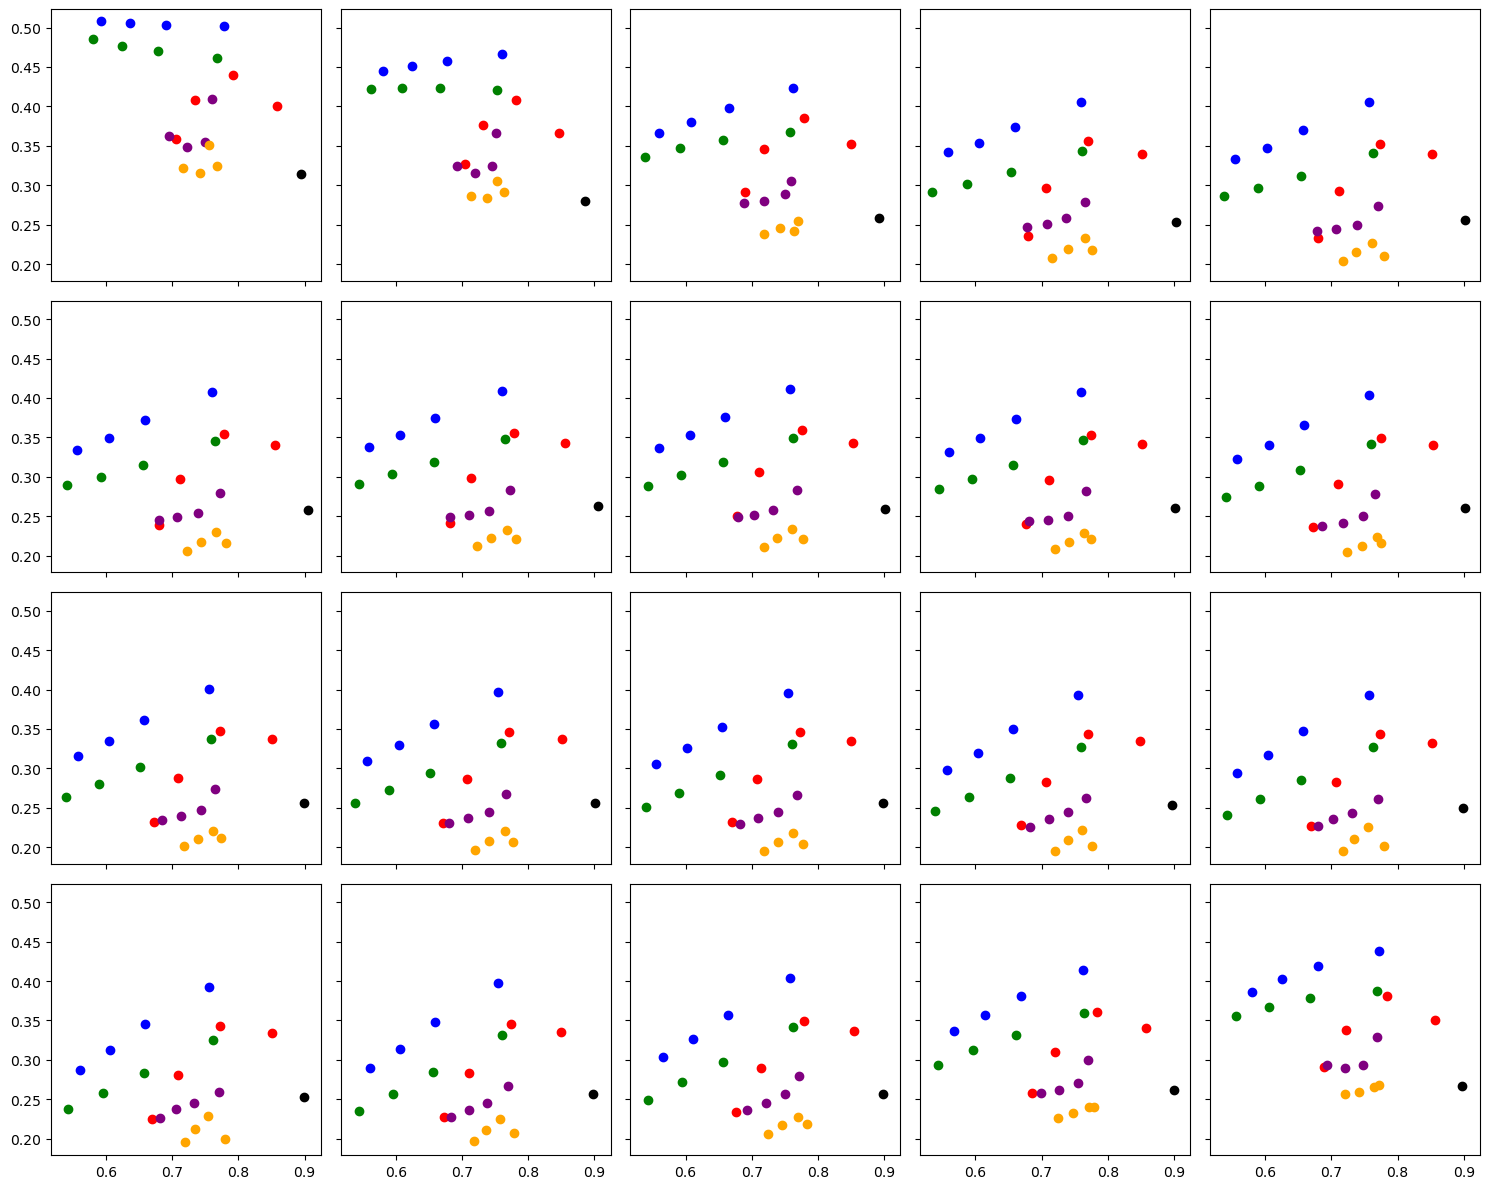

In [6]:
fig,ax = plt.subplots(4,5, sharex=True, sharey=True, figsize=(15,12))
ax = ax.flatten()
sample_letter = available_letters[7]
print(f"Sample letter: {sample_letter}")
sample_files = get_samples_for_letter(sample_letter)
sample_path = sample_files[0]
sequence = load_landmarks(sample_path)
print(sequence.shape)
num = 0
for test in sequence:
    for i in range(test.shape[0]):
        ax[num].scatter(test[i,0],1-test[i,1], color=col_dict[i])
    num += 1
fig.tight_layout()
plt.show()

Sample letter: a
(20, 21, 3)


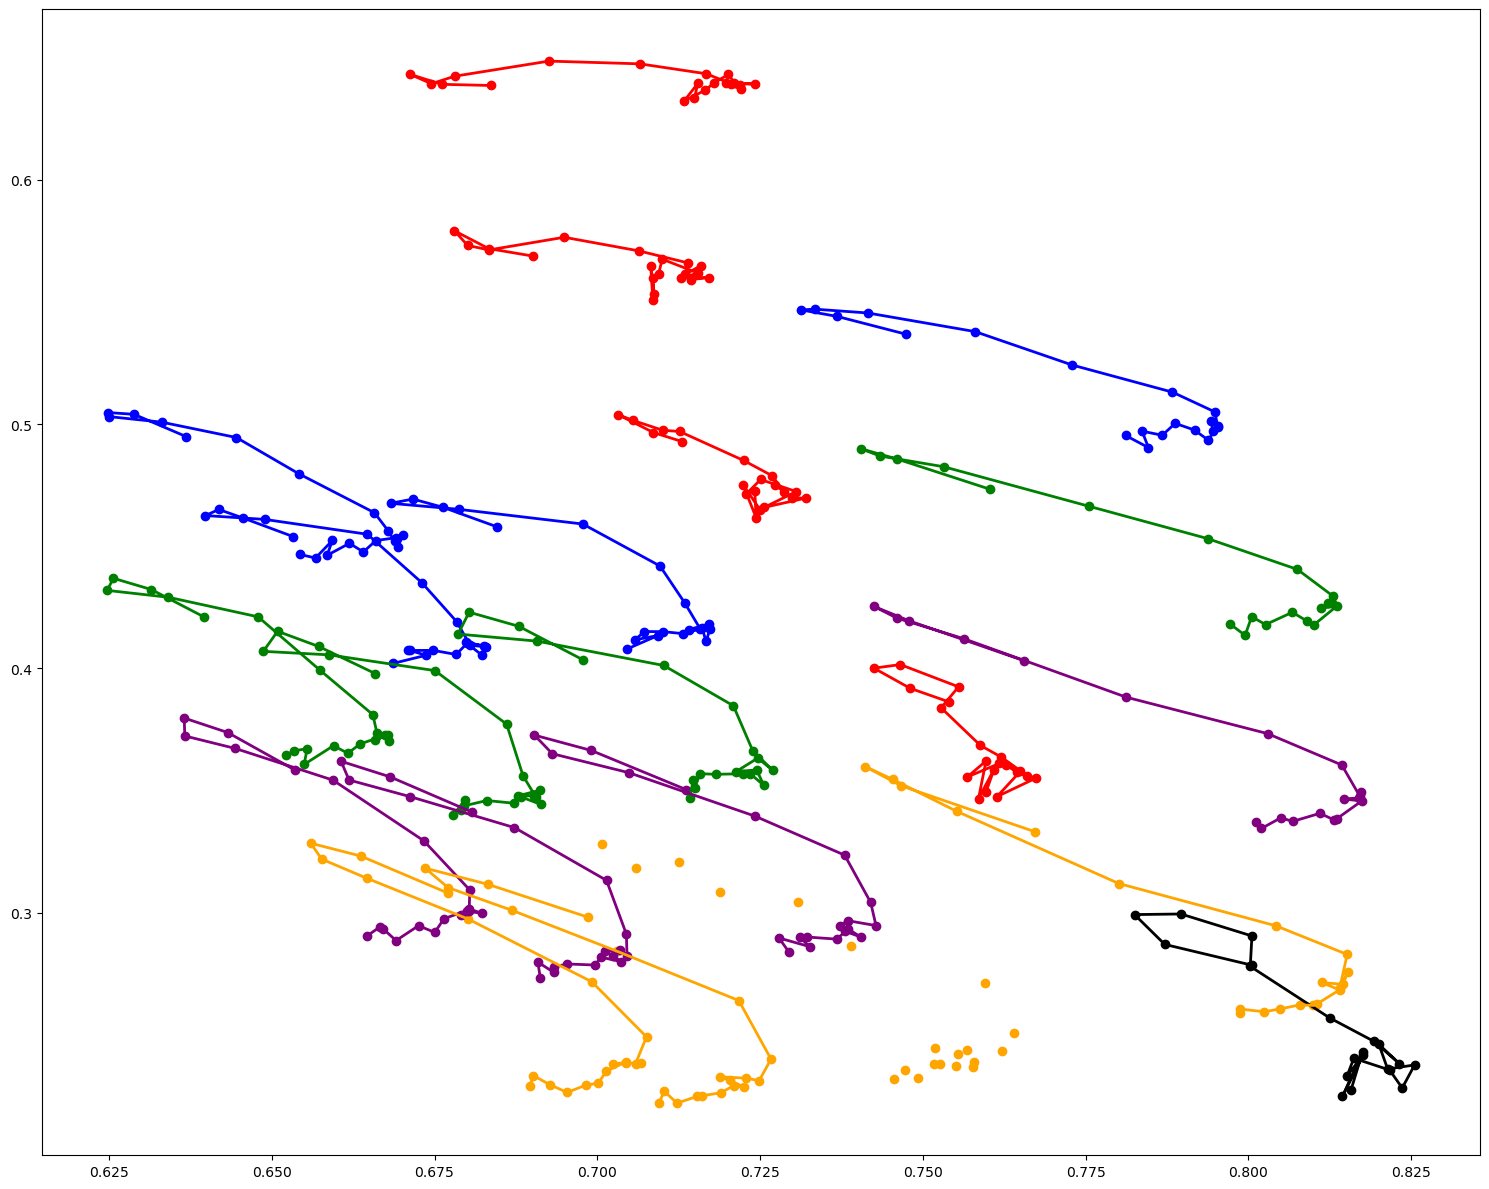

In [17]:
fig,ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(15,12))
sample_letter = available_letters[0]
print(f"Sample letter: {sample_letter}")
sample_files = get_samples_for_letter(sample_letter)
sample_path = sample_files[0]
sequence = load_landmarks(sample_path)
print(sequence.shape)
for num, test in enumerate(sequence):
    ax.plot(sequence[:,num,:2][:,0],1-sequence[:,num,:2][:,1], color=col_dict[num], linewidth=2,)

    for i in range(test.shape[0]):
        ax.scatter(test[i,0],1-test[i,1], color=col_dict[i])

fig.tight_layout()
plt.show()

(20, 2)

## Visualize Sequence Frames

## Compare Different Letters

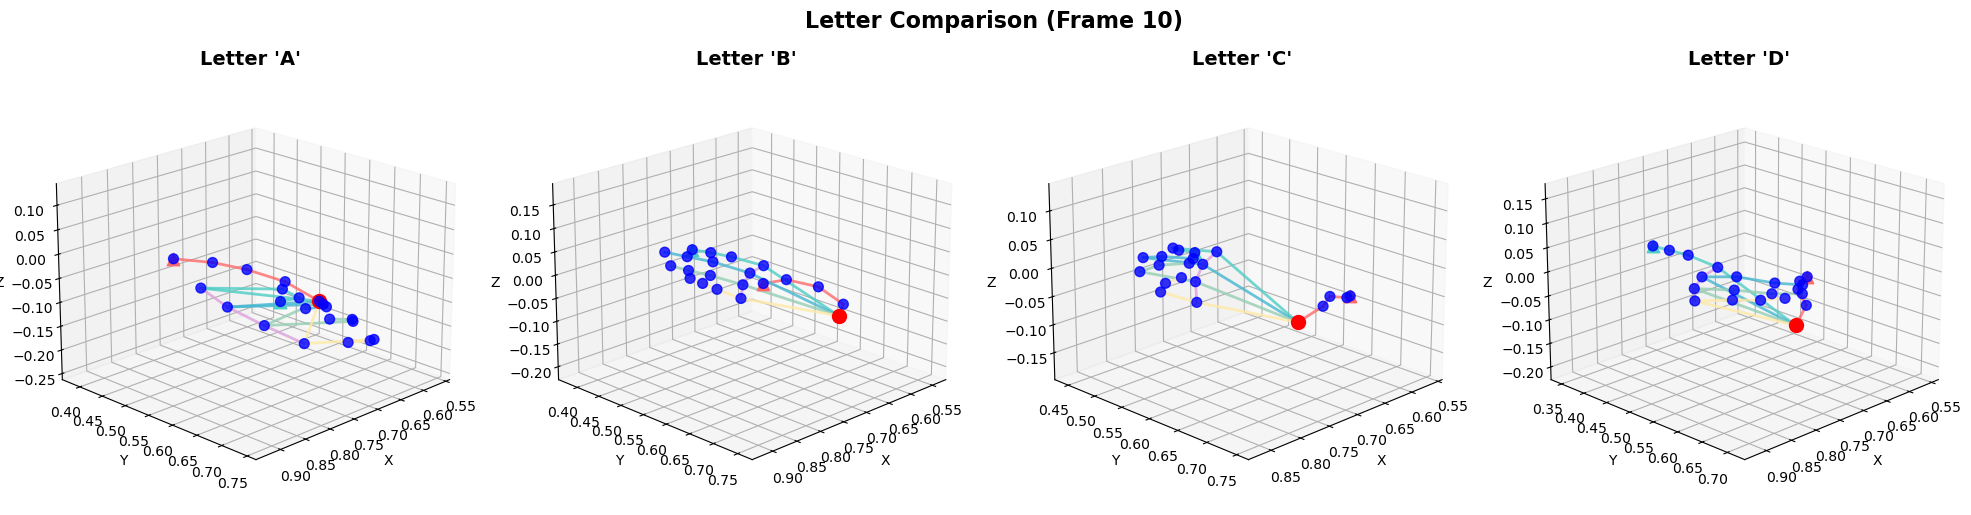

In [21]:
def compare_letters(letters: list[str], frame_idx: int = 10):
    """
    Compare hand poses for different letters at a specific frame.
    """
    n_letters = len(letters)
    fig = plt.figure(figsize=(5*n_letters, 5))
    
    for i, letter in enumerate(letters):
        samples = get_samples_for_letter(letter)
        if samples:
            sequence = load_landmarks(samples[0])
            ax = fig.add_subplot(1, n_letters, i+1, projection='3d')
            plot_hand_3d(
                sequence[frame_idx],
                ax=ax,
                title=f"Letter '{letter.upper()}'",
                elev=20,
                azim=45
            )
    
    fig.suptitle(f"Letter Comparison (Frame {frame_idx})", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Compare some letters
if len(available_letters) >= 4:
    letters_to_compare = available_letters[:4]
    fig = compare_letters(letters_to_compare, frame_idx=10)
    plt.show()

## Interactive Explorer

In [51]:
%matplotlib notebook
def interactive_viewer(letter: str, sample_idx: int, frame: int, elev: int, azim: int):
    """Interactive landmark viewer."""
    samples = get_samples_for_letter(letter)
    if not samples:
        print(f"No samples for letter '{letter}'")
        return
    
    sample_idx = min(sample_idx, len(samples) - 1)
    sequence = load_landmarks(samples[sample_idx])
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    plot_hand_3d(
        sequence[frame],
        ax=ax,
        title=f"Letter '{letter.upper()}' - Sample {sample_idx+1}/{len(samples)} - Frame {frame}/19",
        show_labels=True,
        elev=elev,
        azim=azim
    )
    plt.show()

# Create interactive widget
if available_letters:
    interact(
        interactive_viewer,
        letter=Dropdown(options=available_letters, value=available_letters[0], description='Letter:'),
        sample_idx=IntSlider(min=0, max=10, step=1, value=0, description='Sample:'),
        frame=IntSlider(min=0, max=19, step=1, value=10, description='Frame:'),
        elev=IntSlider(min=-90, max=90, step=10, value=20, description='Elevation:'),
        azim=IntSlider(min=0, max=360, step=10, value=45, description='Azimuth:'),
    )

interactive(children=(Dropdown(description='Letter:', options=('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j…

## Animated Sequence

In [52]:
def create_animation(sequence: np.ndarray, title: str = "", interval: int = 100):
    """
    Create animated 3D visualization of landmark sequence.
    
    Args:
        sequence: (seq_len, 21, 3) landmark array
        title: Animation title
        interval: Milliseconds between frames
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Initialize empty plot elements
    points = ax.scatter([], [], [], c='blue', s=50)
    lines = []
    
    # Create line objects for connections
    for i, (start, end) in enumerate(HAND_CONNECTIONS):
        if i < 4:
            color = FINGER_COLORS['thumb']
        elif i < 8:
            color = FINGER_COLORS['index']
        elif i < 12:
            color = FINGER_COLORS['middle']
        elif i < 16:
            color = FINGER_COLORS['ring']
        elif i < 20:
            color = FINGER_COLORS['pinky']
        else:
            color = FINGER_COLORS['palm']
        line, = ax.plot3D([], [], [], color=color, linewidth=2)
        lines.append(line)
    
    # Set axis limits based on all frames
    all_x = sequence[:, :, 0].flatten()
    all_y = sequence[:, :, 1].flatten()
    all_z = sequence[:, :, 2].flatten()
    
    max_range = np.array([all_x.max()-all_x.min(), all_y.max()-all_y.min(), all_z.max()-all_z.min()]).max() / 2.0
    mid_x = (all_x.max()+all_x.min()) * 0.5
    mid_y = (all_y.max()+all_y.min()) * 0.5
    mid_z = (all_z.max()+all_z.min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    def init():
        return [points] + lines
    
    def update(frame_idx):
        landmarks = sequence[frame_idx]
        x, y, z = landmarks[:, 0], landmarks[:, 1], landmarks[:, 2]
        
        # Update points
        points._offsets3d = (x, y, z)
        
        # Update lines
        for line, (start, end) in zip(lines, HAND_CONNECTIONS):
            line.set_data([x[start], x[end]], [y[start], y[end]])
            line.set_3d_properties([z[start], z[end]])
        
        ax.set_title(f"{title} - Frame {frame_idx}/{len(sequence)-1}", fontsize=14, fontweight='bold')
        return [points] + lines
    
    anim = FuncAnimation(
        fig, update, frames=len(sequence),
        init_func=init, blit=False, interval=interval
    )
    
    plt.close()  # Don't show static figure
    return anim

# Create and display animation
if available_letters and sample_files:
    anim = create_animation(sequence, title=f"Letter '{sample_letter.upper()}'")
    HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'remove_callback'

## Landmark Statistics

In [24]:
def analyze_landmarks(letter: str):
    """Analyze landmark statistics for a letter."""
    samples = get_samples_for_letter(letter)
    if not samples:
        print(f"No samples for '{letter}'")
        return
    
    # Load all samples
    all_sequences = [load_landmarks(s) for s in samples]
    stacked = np.stack(all_sequences)  # (n_samples, seq_len, 21, 3)
    
    print(f"Letter '{letter.upper()}':")
    print(f"  Samples: {len(samples)}")
    print(f"  Shape per sample: {all_sequences[0].shape}")
    
    # Mean hand pose across all samples and frames
    mean_pose = stacked.mean(axis=(0, 1))  # (21, 3)
    std_pose = stacked.std(axis=(0, 1))  # (21, 3)
    
    print(f"\n  Landmark variability (std):")
    for i, name in enumerate(LANDMARK_NAMES):
        std = np.linalg.norm(std_pose[i])
        print(f"    {name}: {std:.4f}")
    
    return mean_pose, std_pose

# Analyze first available letter
if available_letters:
    mean_pose, std_pose = analyze_landmarks(available_letters[0])

Letter 'A':
  Samples: 3
  Shape per sample: (20, 21, 3)

  Landmark variability (std):
    WRIST: 0.0974
    THUMB_CMC: 0.0960
    THUMB_MCP: 0.0999
    THUMB_IP: 0.1038
    THUMB_TIP: 0.1065
    INDEX_MCP: 0.1140
    INDEX_PIP: 0.1168
    INDEX_DIP: 0.1164
    INDEX_TIP: 0.1176
    MIDDLE_MCP: 0.1171
    MIDDLE_PIP: 0.1177
    MIDDLE_DIP: 0.1168
    MIDDLE_TIP: 0.1166
    RING_MCP: 0.1188
    RING_PIP: 0.1194
    RING_DIP: 0.1167
    RING_TIP: 0.1159
    PINKY_MCP: 0.1204
    PINKY_PIP: 0.1205
    PINKY_DIP: 0.1182
    PINKY_TIP: 0.1182


## Variance Visualization

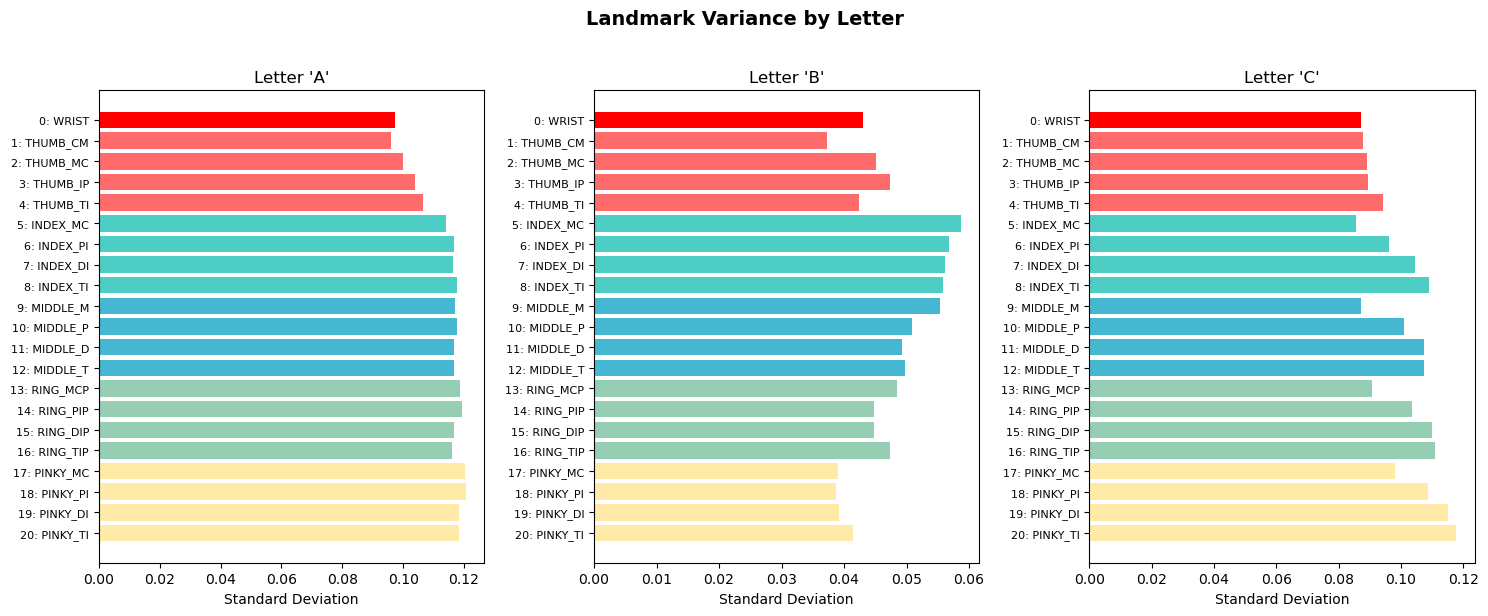

In [25]:
def plot_variance_by_landmark(letters: list[str]):
    """
    Plot landmark variance across letters.
    Shows which landmarks vary most for each letter.
    """
    fig, axes = plt.subplots(1, len(letters), figsize=(5*len(letters), 6))
    if len(letters) == 1:
        axes = [axes]
    
    for ax, letter in zip(axes, letters):
        samples = get_samples_for_letter(letter)
        if not samples:
            continue
        
        all_sequences = [load_landmarks(s) for s in samples]
        stacked = np.stack(all_sequences)
        
        # Calculate variance per landmark
        std_per_landmark = stacked.std(axis=(0, 1))  # (21, 3)
        total_std = np.linalg.norm(std_per_landmark, axis=1)  # (21,)
        
        # Color by finger
        colors = (
            ['red'] +  # wrist
            [FINGER_COLORS['thumb']] * 4 +
            [FINGER_COLORS['index']] * 4 +
            [FINGER_COLORS['middle']] * 4 +
            [FINGER_COLORS['ring']] * 4 +
            [FINGER_COLORS['pinky']] * 4
        )
        
        ax.barh(range(21), total_std, color=colors)
        ax.set_yticks(range(21))
        ax.set_yticklabels([f"{i}: {n[:8]}" for i, n in enumerate(LANDMARK_NAMES)], fontsize=8)
        ax.set_xlabel('Standard Deviation')
        ax.set_title(f"Letter '{letter.upper()}'")
        ax.invert_yaxis()
    
    fig.suptitle('Landmark Variance by Letter', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

if len(available_letters) >= 3:
    fig = plot_variance_by_landmark(available_letters[:3])
    plt.show()

## Fingertip Trajectory

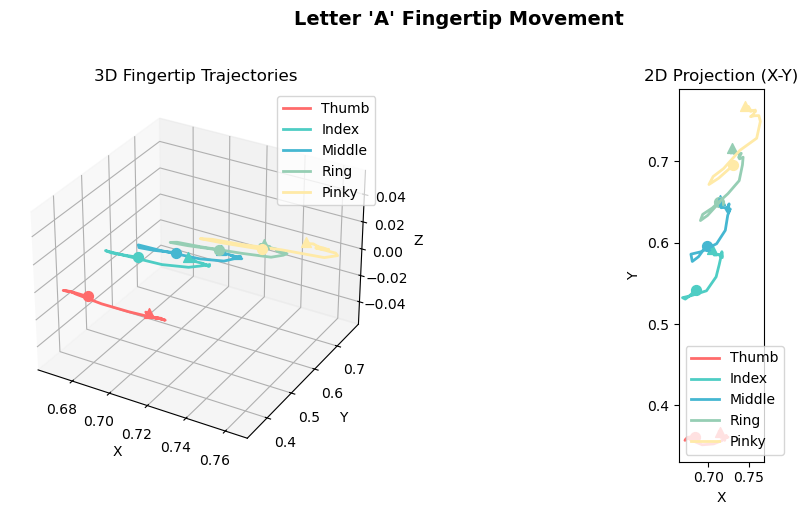

In [ ]:
def plot_fingertip_trajectory(sequence: np.ndarray, title: str = ""):
    """
    Plot the trajectory of fingertips through time.
    
    Fingertip indices: 4 (thumb), 8 (index), 12 (middle), 16 (ring), 20 (pinky)
    """
    fig = plt.figure(figsize=(12, 5))
    
    # 3D trajectory
    ax1 = fig.add_subplot(121, projection='3d')
    
    fingertips = [4, 8, 12, 16, 20]
    names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
    colors = [FINGER_COLORS['thumb'], FINGER_COLORS['index'], 
              FINGER_COLORS['middle'], FINGER_COLORS['ring'], FINGER_COLORS['pinky']]
    
    for tip_idx, name, color in zip(fingertips, names, colors):
        trajectory = sequence[:, tip_idx, :]  # (seq_len, 3)
        ax1.plot3D(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
                   color=color, linewidth=2, label=name)
        # Mark start and end
        ax1.scatter(*trajectory[0], c=color, s=50, marker='o')
        ax1.scatter(*trajectory[-1], c=color, s=50, marker='^')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Fingertip Trajectories')
    ax1.legend()
    
    # 2D projection (X-Y)
    ax2 = fig.add_subplot(122)
    
    for tip_idx, name, color in zip(fingertips, names, colors):
        trajectory = sequence[:, tip_idx, :]
        ax2.plot(trajectory[:, 0], trajectory[:, 1], color=color, linewidth=2, label=name)
        ax2.scatter(trajectory[0, 0], trajectory[0, 1], c=color, s=50, marker='o')
        ax2.scatter(trajectory[-1, 0], trajectory[-1, 1], c=color, s=50, marker='^')
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('2D Projection (X-Y)')
    ax2.legend()
    ax2.set_aspect('equal')
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

if available_letters and sample_files:wha
    fig = plot_fingertip_trajectory(sequence, title=f"Letter '{sample_letter.upper()}' Fingertip Movement")
    plt.show()

## Save Figures

In [ ]:
FIGURES_DIR = PROJECT_ROOT / "blog" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Save comparison figure if we have multiple letters
if len(available_letters) >= 4:
    fig = compare_letters(available_letters[:4], frame_idx=10)
    fig.savefig(FIGURES_DIR / '07-landmarks-letter-comparison.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {FIGURES_DIR / '07-landmarks-letter-comparison.png'}")
    plt.close()

# Save trajectory figure
if available_letters and sample_files:
    fig = plot_fingertip_trajectory(sequence, title=f"Letter '{sample_letter.upper()}' Fingertip Movement")
    fig.savefig(FIGURES_DIR / '07-landmarks-fingertip-trajectory.png', dpi=150, bbox_inches='tight')
    print(f"Saved: {FIGURES_DIR / '07-landmarks-fingertip-trajectory.png'}")
    plt.close()

print("\nDone!")